<a href="https://colab.research.google.com/github/RaghulJ06/DSAI/blob/main/classify_network_traffic_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


Load and Preprocess Dataset

In [18]:
# Load dataset (sample)
df = pd.read_csv("/content/DDos.pcap_ISCX.csv")

print(df.head())

    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [43]:
#Find any duplicates
duplicates = df[df.duplicated(keep=False)]
print(duplicates)
df.duplicated().any()
#Drop duplicates
df = df.drop_duplicates()

         Destination Port   Flow Duration   Total Fwd Packets  \
76                     21              50                   1   
386                   465              49                   2   
405                   137              22                  13   
422                    53             259                   2   
443                   443               4                   2   
...                   ...             ...                 ...   
225540                 53             157                   2   
225629                443             113                   2   
225639                137              22                  13   
225660                443              52                   2   
225687                137               4                   2   

         Total Backward Packets  Total Length of Fwd Packets  \
76                            2                            0   
386                           0                           37   
405                        

Handle outliers

In [52]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df_cleaned = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) |
                  (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Display cleaned dataset
print("Cleaned Dataset (Outliers Removed):")
print(df_cleaned)

✅ Cleaned Dataset (Outliers Removed):
         Destination Port   Flow Duration   Total Fwd Packets  \
1408                   80          418899                   3   
18883                  80         1293792                   3   
18887                  80          642654                   3   
18889                  80          306157                   3   
18891                  80          682575                   3   
...                   ...             ...                 ...   
197532                 80          154071                   4   
197534                 80          155871                   4   
197536                 80          166023                   4   
197538                 80          163071                   4   
197542                 80          155039                   4   

         Total Backward Packets  Total Length of Fwd Packets  \
1408                          0                           18   
18883                         7                      

In [53]:
#Find the coloumns with catogorical value
{column: len(df[column].unique()) for column in df.select_dtypes('object').columns}

{' Label': 2}

In [54]:
# Handle missing and infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Encode categorical labels
le = LabelEncoder()
df['EncodedLabel'] = le.fit_transform(df[' Label'])

# Select numerical features
X = df.select_dtypes(include=[np.number]).drop(['EncodedLabel'], axis=1)
y = df['EncodedLabel']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Address class imbalance
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

<ipython-input-54-92e3b52134d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-54-92e3b52134d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-54-92e3b52134d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EncodedLabel'] = le.fit_transform(df[' Label'])


Exploratory Data Analysis (EDA)

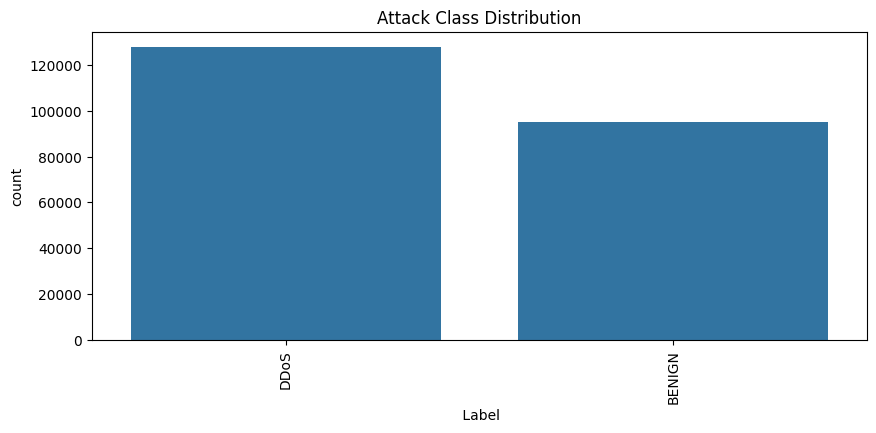

In [55]:
# Plot class distribution
plt.figure(figsize=(10, 4))
sns.countplot(x=df[' Label'], order=df[' Label'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Attack Class Distribution")
plt.show()


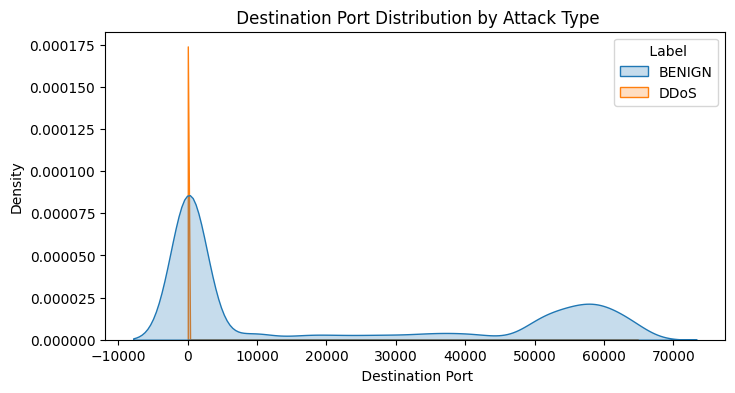

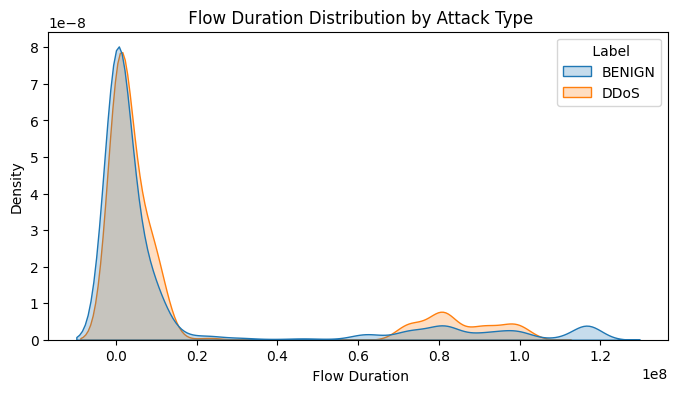

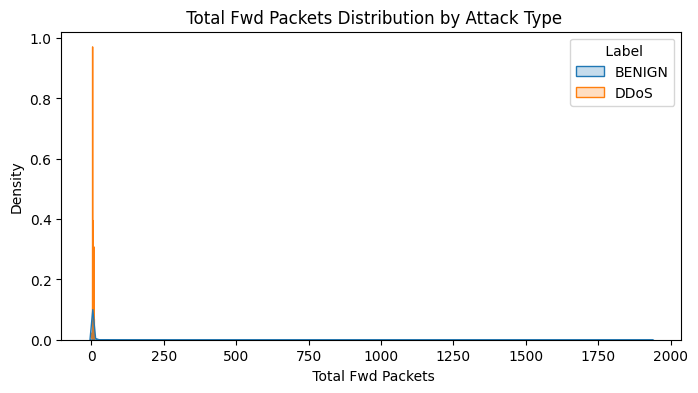

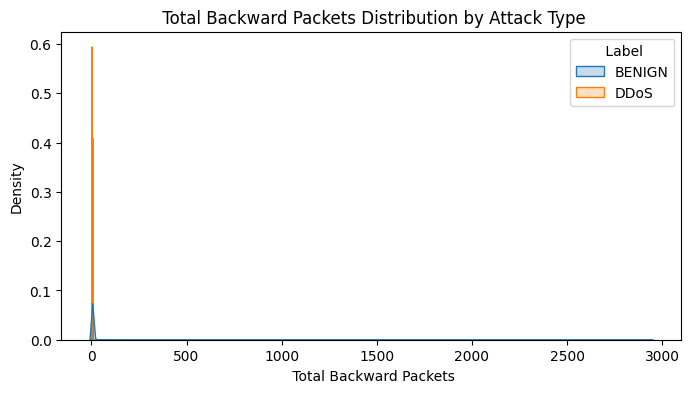

In [56]:
# KDE plots for top features
top_features = X.columns[:4]
for feature in top_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=feature, hue=' Label', fill=True, common_norm=False)
    plt.title(f'{feature} Distribution by Attack Type')
    plt.show()


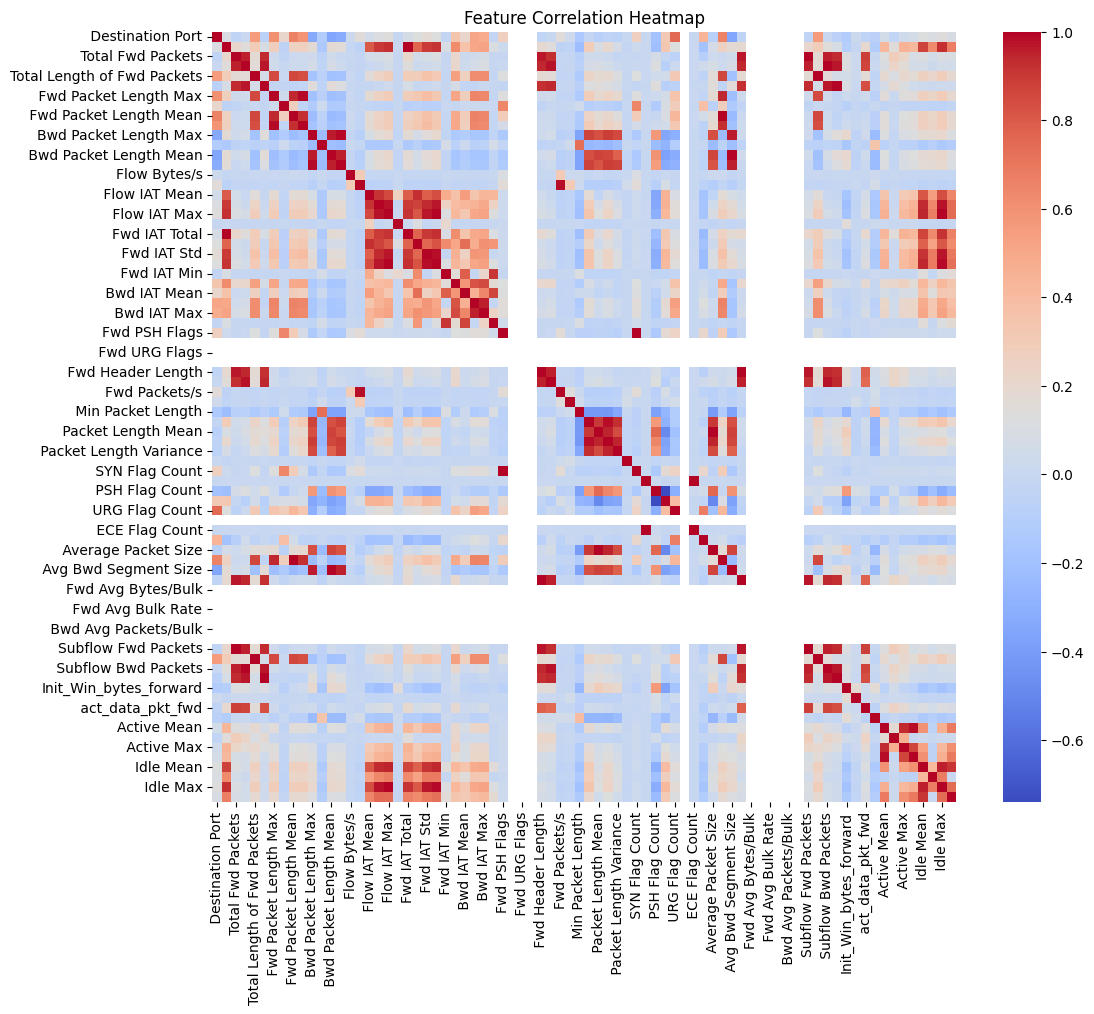

In [57]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(X_scaled, columns=X.columns).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



In [58]:
# 3. Feature Selection

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_resampled, y_resampled)
importances = model.feature_importances_
feature_names = X.columns
selected_final = list(pd.Series(importances, index=feature_names).nlargest(20).index)


In [59]:
print(selected_final)

[' ACK Flag Count', ' Destination Port', ' Bwd Packet Length Mean', ' URG Flag Count', 'Bwd Packet Length Max', ' Packet Length Mean', ' Bwd Packet Length Std', ' Down/Up Ratio', ' Avg Bwd Segment Size', ' Average Packet Size', ' Fwd Packet Length Mean', ' PSH Flag Count', ' Packet Length Std', ' Packet Length Variance', ' Fwd IAT Std', ' Avg Fwd Segment Size', ' min_seg_size_forward', 'Fwd IAT Total', ' Max Packet Length', ' Flow IAT Max']


Evaluate Classifiers

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_selected = pd.DataFrame(X_scaled, columns=feature_names)[selected_final]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Decision Tree Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19014
        DDoS       1.00      1.00      1.00     25603

    accuracy                           1.00     44617
   macro avg       1.00      1.00      1.00     44617
weighted avg       1.00      1.00      1.00     44617

Accuracy: 0.9998

Random Forest Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19014
        DDoS       1.00      1.00      1.00     25603

    accuracy                           1.00     44617
   macro avg       1.00      1.00      1.00     44617
weighted avg       1.00      1.00      1.00     44617

Accuracy: 0.9998

Extra Trees Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19014
        DDoS       1.00      1.00      1.00     25603

    accuracy                           1.00     44617
   macro avg       1.00    

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:37:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19014
        DDoS       1.00      1.00      1.00     25603

    accuracy                           1.00     44617
   macro avg       1.00      1.00      1.00     44617
weighted avg       1.00      1.00      1.00     44617

Accuracy: 0.9999


Ensemble Methods

In [61]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

voting_soft = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('et', ExtraTreesClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
], voting='soft')

stacking = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier()),
    ('et', ExtraTreesClassifier())
], final_estimator=LogisticRegression(max_iter=1000))

for name, model in {"Voting Soft": voting_soft, "Stacking": stacking}.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:38:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Soft Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19014
        DDoS       1.00      1.00      1.00     25603

    accuracy                           1.00     44617
   macro avg       1.00      1.00      1.00     44617
weighted avg       1.00      1.00      1.00     44617

Accuracy: 0.9998

Stacking Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19014
        DDoS       1.00      1.00      1.00     25603

    accuracy                           1.00     44617
   macro avg       1.00      1.00      1.00     44617
weighted avg       1.00      1.00      1.00     44617

Accuracy: 0.9998


Metrics Visualization

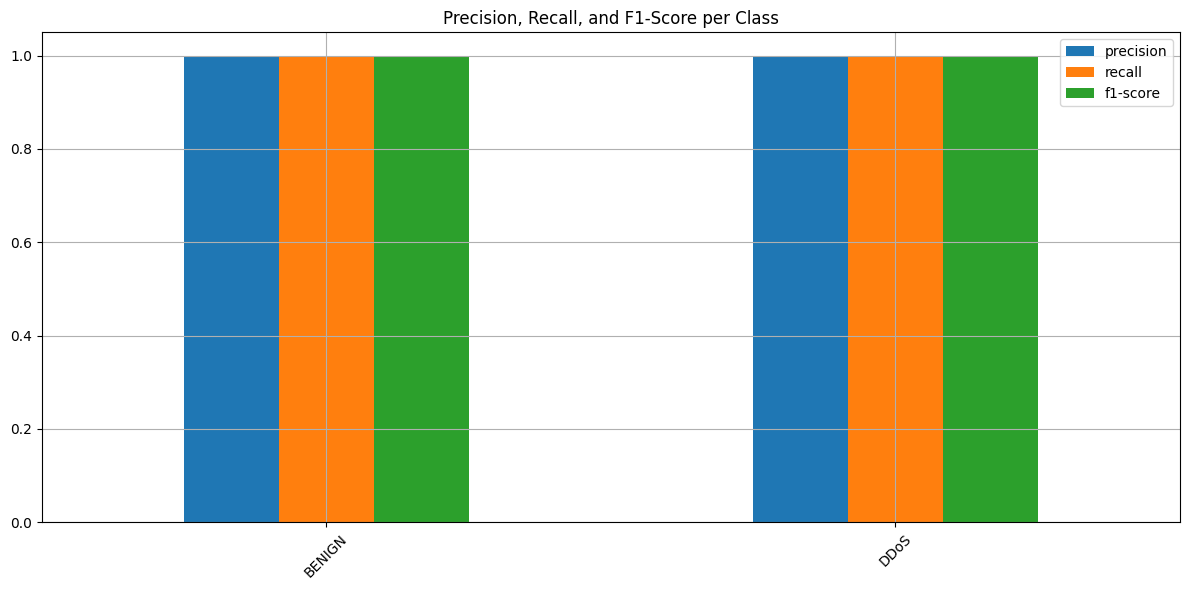

In [62]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
df_report = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title("Precision, Recall, and F1-Score per Class")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Feature Importance Plot

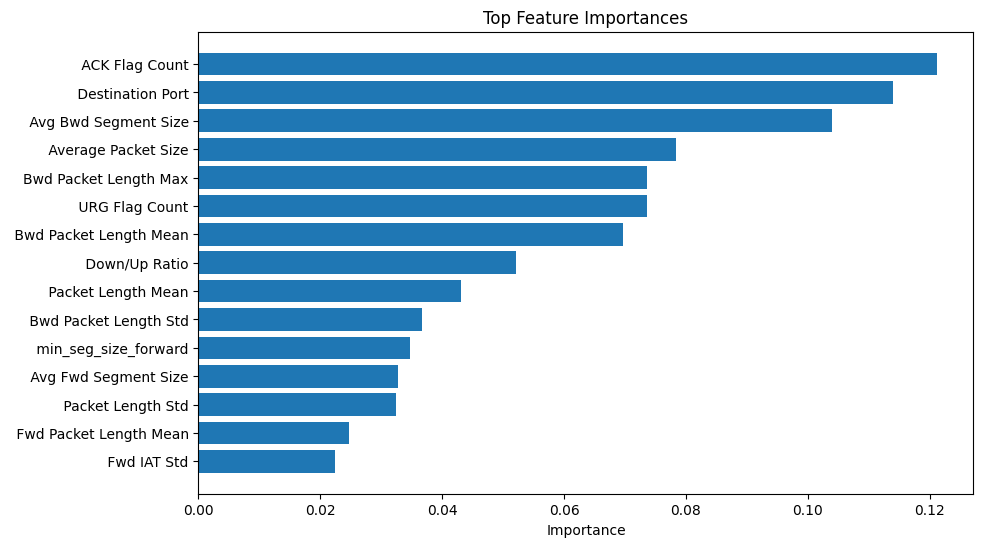

In [63]:
final_model = ExtraTreesClassifier()
final_model.fit(X_train, y_train)
importances = final_model.feature_importances_
sorted_idx = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [selected_final[i] for i in sorted_idx])
plt.title("Top Feature Importances")
plt.xlabel("Importance")
plt.show()
